# Predicting a exponentially decacying noisy sine function with overlapping periods

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import seed, random
%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [102]:
np.random.seed(1337)  # for reproducibility

# Simulate data
cycle = 100
step = 0.1
noise = 0.00 # standard deviation from 0
decaying_coef = 0.01

end_pt = 2 * np.pi * cycle
t = np.arange(0, end_pt, step)
a = np.sin(t) #* np.sin(0.5 * t) * np.sin(0.2 * t) * np.sin(0.3 * t) * np.sin(2 * t)
a_noisy = a + np.random.normal(0, noise, a.size)
a_decaying = a_noisy * np.exp(-decaying_coef * t)
pdata = pd.DataFrame({"a_noisy":a_decaying})
data = pdata

# Note: If noise is not modulated by the exponential function, it will overwhelm the signal near the end of the data sequence
# which is where test data is picked from. We can modulate it in simulated environment but in experiments, we may have to discard
# data near the end of the motion.

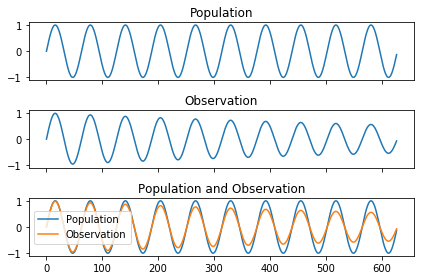

In [103]:
# visualize data
n_plot = int(a.size / 10)

_, axarr = plt.subplots(3, sharex=True, sharey=True)
axarr[0].plot(a[:n_plot])
axarr[0].set_title('Population')
axarr[1].plot(a_decaying[:n_plot])
axarr[1].set_title('Observation')
axarr[2].plot(a[:n_plot], label="Population")
axarr[2].plot(a_decaying[:n_plot], label="Observation")
axarr[2].set_title('Population and Observation')
axarr[2].legend()
plt.tight_layout()
plt.show()

In [104]:
def _load_data(data, n_prev = 50):
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(df) * (1 - test_size)))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data, 0.3)

In [113]:
# define model structure
model = Sequential()
# model.add(Bidirectional(CuDNNLSTM(units=5, return_sequences=False), input_shape=(None, 1)))
model.add(Bidirectional(LSTM(units=10, return_sequences=False), input_shape=(None, 1)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=True)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
# model.add(Dense(units=5, activation="linear"))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [114]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_split=0.1)

Train on 3914 samples, validate on 435 samples
Epoch 1/40
3914/3914 [==============================] - 4s 1ms/step - loss: 0.0386 - val_loss: 4.2829e-05
Epoch 2/40
3914/3914 [==============================] - 2s 457us/step - loss: 0.0098 - val_loss: 2.6439e-05
Epoch 3/40
3914/3914 [==============================] - 2s 489us/step - loss: 7.7370e-04 - val_loss: 3.6632e-06
Epoch 4/40
3914/3914 [==============================] - 2s 493us/step - loss: 3.6626e-04 - val_loss: 3.9629e-06
Epoch 5/40
3914/3914 [==============================] - 2s 487us/step - loss: 2.3301e-04 - val_loss: 5.8799e-06
Epoch 6/40
3914/3914 [==============================] - 2s 492us/step - loss: 1.5013e-04 - val_loss: 2.4588e-06
Epoch 7/40
3914/3914 [==============================] - 2s 480us/step - loss: 9.9279e-05 - val_loss: 5.4329e-07
Epoch 8/40
3914/3914 [==============================] - 2s 492us/step - loss: 6.4454e-05 - val_loss: 1.5679e-07
Epoch 9/40
3914/3914 [==============================] - 2s 494us/st

dict_keys(['val_loss', 'loss'])
40


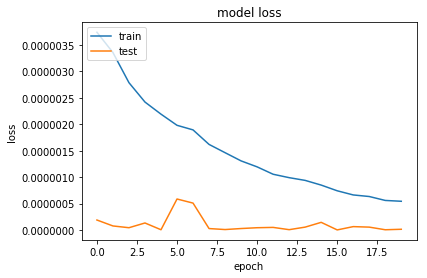

In [115]:
print(history.history.keys())
print(len(history.history['val_loss']))
# summarize history for loss
plt.plot(history.history['loss'][-20:])
plt.plot(history.history['val_loss'][-20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [116]:
# evaluate model fit
score = model.evaluate(X_test, y_test)
print('Test score:', score)

1835/1835 [==============================] - 0s 191us/step
Test score: 1.2642298138539024e-08


In [117]:
# perform modelling
X_model = X_test[0]
modelled_data = []
dims = 1, X_model.shape[0], X_model.shape[1]
for i in range(len(y_test)*2):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(list(next_step[0]))
    X_model = np.append(X_model[1:], next_step)

# evaluate
print(np.mean((modelled_data[:len(y_test)]-y_test)**2))

2.585942423427985


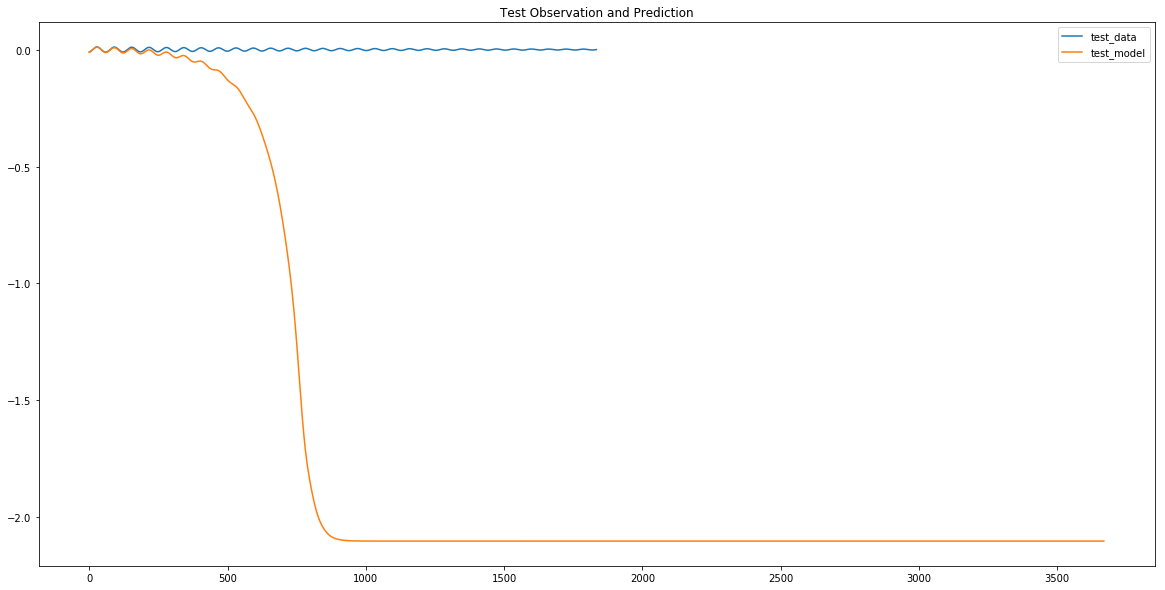

In [118]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:], label='test_data')
plt.plot(modelled_data[:], label='test_model')
plt.title('Test Observation and Prediction')
plt.legend()

In [119]:
# visualize predictions
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

-0.0001028881
8.95101247264569e-06


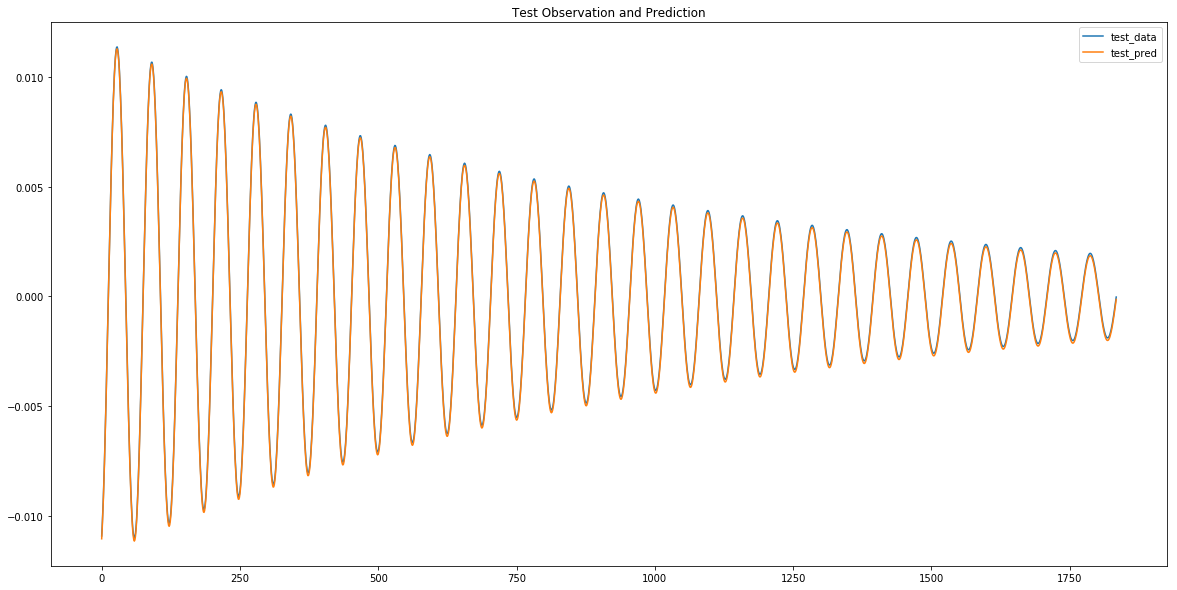

In [120]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:], label='test_data')
plt.plot(test_prediction[:], label='test_pred')
plt.title('Test Observation and Prediction')
plt.legend()
print(np.mean(test_prediction))
print(np.mean(y_test))
# Note: Prediction has a positive bias

-0.0013913481
-0.0017580405638694186


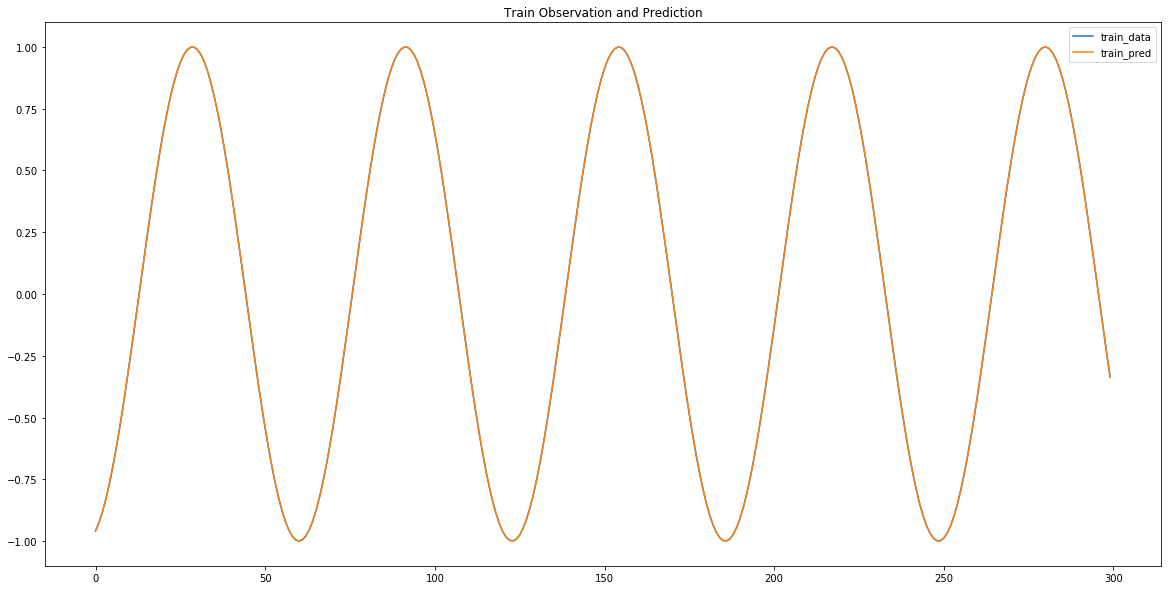

In [37]:
plt.figure(figsize=(20,10))
plt.plot(y_train[0:300], label='train_data')
plt.plot(train_prediction[0:300], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()
print(np.mean(train_prediction))
print(np.mean(y_train))